# Summary

This notebook presents the survival analysis performed on bulk RNA-seq data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from sklearn import preprocessing
import itertools
import random
from scipy.spatial import distance as ssd
import scipy
from tqdm import tqdm
import scipy.spatial.distance
from lifelines import KaplanMeierFitter
#logrank_test
from lifelines.statistics import logrank_test
plt.ion()
plt.show()
import pickle
import os
import sys
sys.path.append("..")

%load_ext autoreload
%autoreload 2

random_state=0
random.seed( random_state )
np.random.seed(random_state)


In [2]:
from lifelines.datasets import load_waltons
df = load_waltons() # returns a Pandas DataFrame
print(df.shape)
print(df.head())
"""
    T  E    group
0   6  1  miR-137
1  13  1  miR-137
2  13  1  miR-137
3  13  1  miR-137
4  19  1  miR-137
"""

T = df['T']
E = df['E']

df.group.value_counts()

(163, 3)
      T  E    group
0   6.0  1  miR-137
1  13.0  1  miR-137
2  13.0  1  miR-137
3  13.0  1  miR-137
4  19.0  1  miR-137


control    129
miR-137     34
Name: group, dtype: int64

In [3]:
!ls ../data

10X_PBMC_gmm_adapted_ratkowsky_lance.pkl
10X_PBMC_hdbscan_adapted_silhouette.pkl
BRCA_gmm_adapted_ratkowsky_lance.pkl
BRCA_hdbscan_adapted_ratkowsky_lance.pkl
BRCA_hdbscan_adapted_silhouette.pkl
GA
KIRP_gmm_adapted_ratkowsky_lance.pkl
KIRP_gmm_adapted_silhouette.pkl
KIRP_hdbscan_adapted_ratkowsky_lance.pkl
KIRP_hdbscan_adapted_silhouette.pkl
cluster_analysis
discovery_vs_semisupervised.npy
loss_comparaison.pkl
microarray
microarray_others.pkl
microarray_others_silhouette.pkl
module_hdbscan_adapted_silhouette.pkl
mouse_ES_cell_hdbscan_adapted_silhouette.pkl
nn_data
rna_data
sampling_results_0.pkl
sampling_results_1.pkl
sampling_results_2.pkl
sampling_results_3.pkl
sampling_results_4.pkl
scRNAseq
simulated_gmm.pkl
simulated_hdbscan.pkl
speed_comparaison1.pkl


In [15]:
filename ="BRCA"#"KIRP" #
df = pd.read_pickle(f"../data/rna_data/{filename}_survival.pkl")
solutions = pd.read_pickle(f"../data/{filename}_gmm_adapted_ratkowsky_lance.pkl")
print(df.shape)
df.head()

(1031, 140)


,vital_status,days_to_death,days_to_last_followup,additional_studies,additional_surgery_locoregional_procedure,additional_surgery_metastatic_procedure,age_at_initial_pathologic_diagnosis,anatomic_neoplasm_subdivision-2,anatomic_neoplasm_subdivision-3,anatomic_neoplasm_subdivision-4,...,subspace_0,subspace_1,subspace_2,subspace_3,subspace_4,subspace_5,subspace_6,subspace_7,subspace_8,subspace_9
0,alive,NaN,1477,NaN,NaN,NaN,42,right lower outer quadrant,NaN,NaN,...,0,0,1,0,1,0,1,0,1,1
1,alive,NaN,1471,NaN,NaN,NaN,63,NaN,NaN,NaN,...,0,0,1,0,1,0,0,1,0,1
2,alive,NaN,584,NaN,NaN,NaN,40,NaN,NaN,NaN,...,1,1,0,1,1,1,1,1,0,0
3,dead,1920,NaN,NaN,no,no,39,right,NaN,NaN,...,0,0,0,0,0,0,1,1,0,0
4,alive,NaN,1099,NaN,NaN,NaN,53,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0


In [16]:
df["vital_status"].value_counts()

alive    891
dead     140
Name: vital_status, dtype: int64

In [17]:
df["event"] = df["vital_status"].apply(lambda x : int(x == 'dead'))

df["t"] = df.apply(lambda row: float(row["days_to_last_followup"])
                   if row["vital_status"] == "alive" else float(row["days_to_death"]),
                   axis=1)

df = df[df.columns[-(solutions.shape[0] +2 ):]]

df = df.dropna()

df

,subspace_0,subspace_1,subspace_2,subspace_3,subspace_4,subspace_5,subspace_6,subspace_7,subspace_8,subspace_9,event,t
0,0,0,1,0,1,0,1,0,1,1,0,1477.0
1,0,0,1,0,1,0,0,1,0,1,0,1471.0
2,1,1,0,1,1,1,1,1,0,0,0,584.0
3,0,0,0,0,0,0,1,1,0,0,1,1920.0
4,0,0,0,0,0,1,0,0,0,0,0,1099.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1026,0,0,1,0,1,0,0,0,0,1,0,2033.0
1027,0,0,1,0,0,0,1,0,0,0,0,883.0
1028,0,0,1,0,0,0,1,0,0,1,0,467.0
1029,1,0,0,0,0,0,1,1,1,1,0,488.0


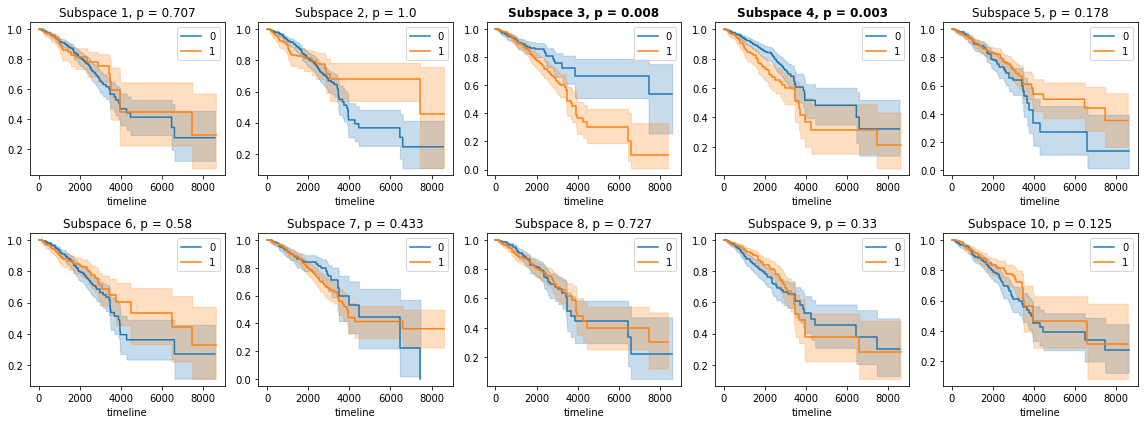

In [18]:
n_cols = 5
n_rows = solutions.shape[0]//n_cols
plt.figure(figsize=(16, n_rows * 3))
significant = []
for i in range(20):
    if i>9:
        break
    feature = f"subspace_{i}"
    ax = plt.subplot(n_rows,n_cols,i+1)
    kmf = KaplanMeierFitter()
    values = df[feature].unique()
    p_value = ""
    if len(values) == 2:
        results=logrank_test(df[df[feature] == values[0]]["t"].values,
                         df[df[feature] == values[1]]["t"].values,
                         event_observed_A=df[df[feature] == values[0]]["event"].values, 
                         event_observed_B=df[df[feature] == values[1]]["event"].values)
        p_value = f"p = {round(results.p_value, 3)}"
        if results.p_value < 0.05:
            fontweight = "bold"
            significant.append(i)
        else:
            fontweight = "normal"

    for name, grouped_df in df.groupby(feature):
        kmf.fit(grouped_df["t"], grouped_df["event"], label=name)
        kmf.plot(ax=ax)
    plt.title(f"Subspace {i+1}, {p_value}", fontweight = fontweight);
# plt.suptitle(f"Survival curves and logrank test p-values for {filename}")
plt.tight_layout()
plt.savefig(f"../images/{filename}_survival.pdf", bbox_inches='tight')

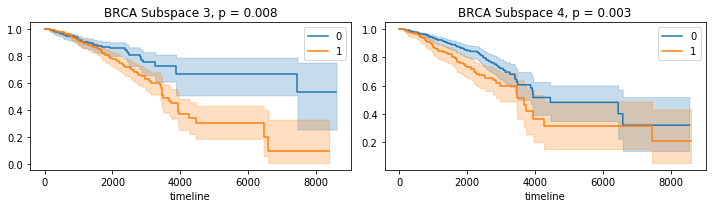

In [19]:
n_cols = len(significant)
n_rows = 1
plt.figure(figsize=(5* len(significant), n_rows * 3))

for ii, i in enumerate(significant):
    feature = f"subspace_{i}"
    ax = plt.subplot(n_rows,n_cols,ii+1)
    kmf = KaplanMeierFitter()
    values = df[feature].unique()
    p_value = ""
    if len(values) == 2:
        results=logrank_test(df[df[feature] == values[0]]["t"].values,
                         df[df[feature] == values[1]]["t"].values,
                         event_observed_A=df[df[feature] == values[0]]["event"].values, 
                         event_observed_B=df[df[feature] == values[1]]["event"].values)
        p_value = f"p = {round(results.p_value, 3)}"


    for name, grouped_df in df.groupby(feature):
        kmf.fit(grouped_df["t"], grouped_df["event"], label=name)
        kmf.plot(ax=ax)
    plt.title(f"{filename} Subspace {i+1}, {p_value}", fontweight = fontweight);
# plt.suptitle(f"Survival curves and logrank test p-values for {filename}")
plt.tight_layout()
plt.savefig(f"../images/imp_{filename}_survival.pdf", bbox_inches='tight')
plt.savefig(f"../images/imp_{filename}_survival.png", bbox_inches='tight')